In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras import backend as K
import seaborn as sns

### Exploring Gram Matrix

In [2]:
image1 = cv2.imread('../data/grass1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image1,(200, 200))

In [3]:
image2 = cv2.imread('../data/grass2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2 = cv2.resize(image2,(200, 200))

### Feature maps of similar pictures

We select a specific layer from the pretrained model and see how the first three feature maps see the image.


We can see both images have similar feature maps. This is the basic theory behind the gram matrix and the style loss described in the paper.

In [4]:
pre_trained_model = vgg19.VGG19(weights="imagenet", include_top=False)
gram_layer = "block3_conv1"
gram_model_output = Model(inputs = pre_trained_model.inputs, outputs = pre_trained_model.get_layer(gram_layer).output)
image1_pred = gram_model_output.predict(np.expand_dims(image1,axis = 0)) #feature maps from picure 1
image2_pred = gram_model_output.predict(np.expand_dims(image2,axis = 0)) #feature maps from picture 2

1/1 [==============================] - 0s 42ms/step


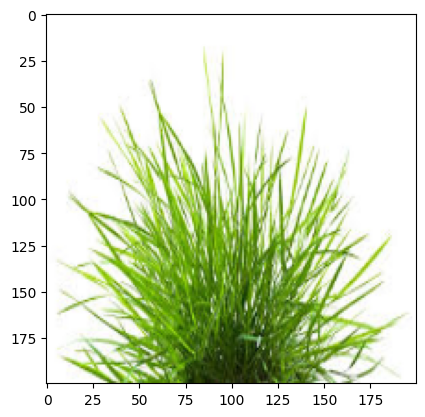

In [5]:
plt.imshow(image1)

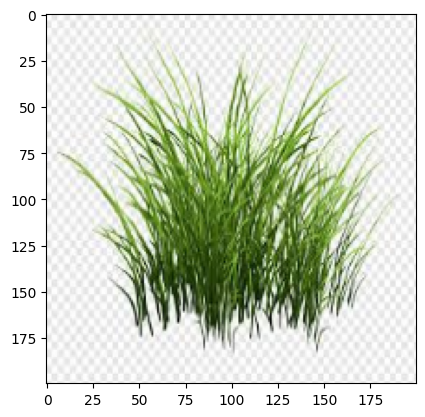

In [6]:
plt.imshow(image2)

### First feature maps for both pictures

<Axes: >

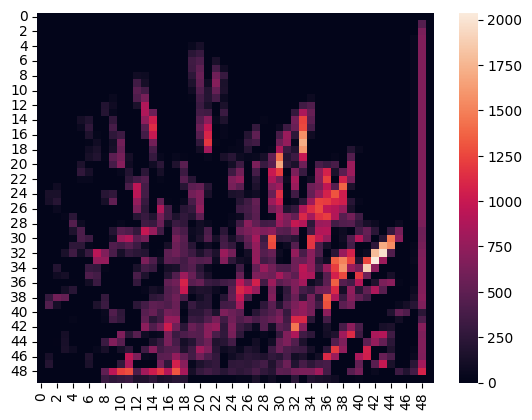

In [7]:
sns.heatmap(image1_pred[0][:,:,0:1].squeeze())

<Axes: >

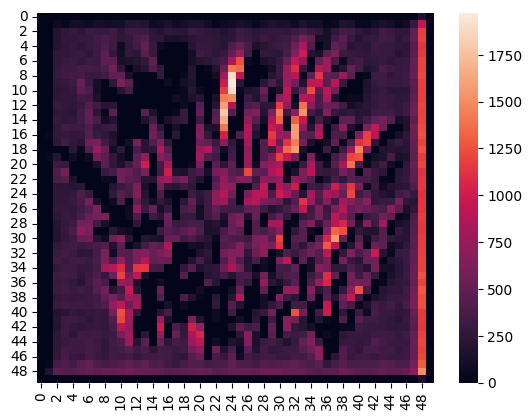

In [8]:
sns.heatmap(image2_pred[0][:,:,0:1].squeeze())

### Second feature maps for both pictures

<Axes: >

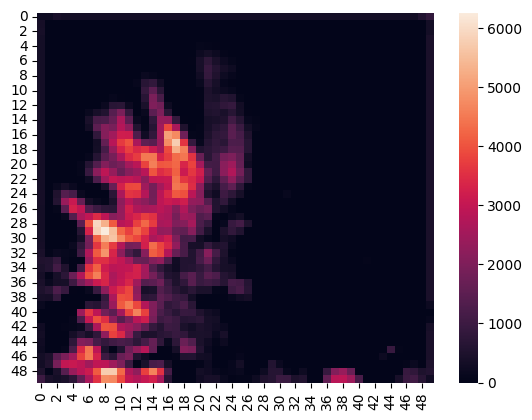

In [9]:
sns.heatmap(image1_pred[0][:,:,1:2].squeeze())

<Axes: >

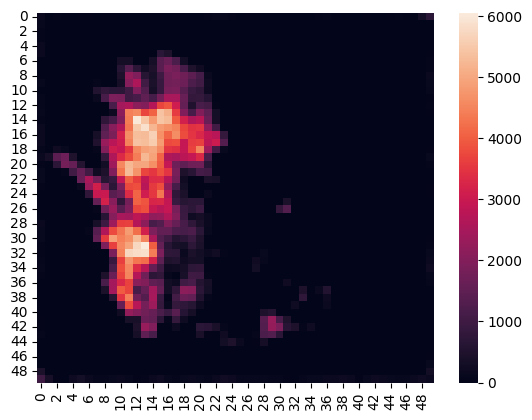

In [10]:
sns.heatmap(image2_pred[0][:,:,1:2].squeeze())

### Third feature maps for both pictures

<Axes: >

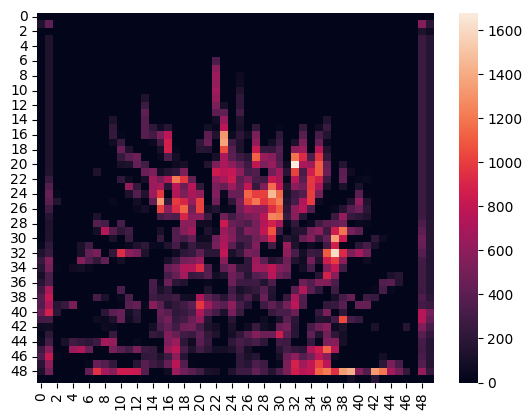

In [11]:
sns.heatmap(image1_pred[0][:,:,2:3].squeeze())

<Axes: >

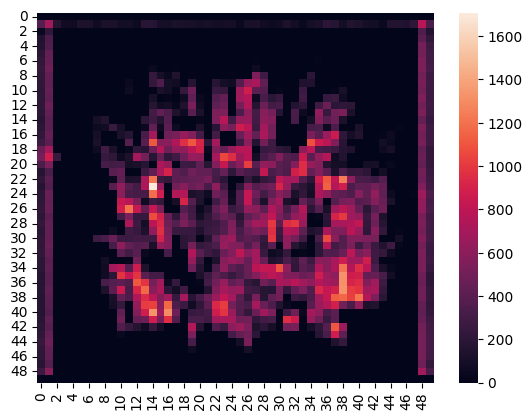

In [12]:
sns.heatmap(image2_pred[0][:,:,2:3].squeeze())

### Gram Matrix

The Gram matrix is computed by taking the dot product of each feature map with every other, resulting in a matrix that represents their "importance" or correlation. Larger values in the feature maps lead to higher values in the corresponding matrix positions. The diagonal of this matrix represents the dot product of each feature map with itself. Below is the standard code for calculating the Gram matrix.

In [13]:
feature_maps = tf.constant([[[1, 2, 3], [4, 5, 6],[7, 8, 9]],
            [[10, 20, 30], [40, 50, 60],[70, 80, 90]],[[100, 200, 300], [400, 500, 600],[700, 800, 900]]])
feature_maps #each dimension in axis 2 would be a feature map extracted from some layer in the pretrained model

<tf.Tensor: shape=(3, 3, 3), dtype=int32, numpy=
array([[[  1,   2,   3],
        [  4,   5,   6],
        [  7,   8,   9]],

       [[ 10,  20,  30],
        [ 40,  50,  60],
        [ 70,  80,  90]],

       [[100, 200, 300],
        [400, 500, 600],
        [700, 800, 900]]])>

In [14]:
#transpose columns to be rows, and each dimension in axis 2 is 
#the concatenation of the first columns of each feature map
permuted_channels = tf.keras.backend.permute_dimensions(feature_maps, pattern=(2,0,1)) 

flatten = tf.keras.backend.batch_flatten(permuted_channels) #flatten each feature map into one vector

#transpose the matrix formed by the transposed vector. (the amount of feature maps is the amount of rows)
transpose = tf.keras.backend.transpose(flatten)

In [15]:
permuted_channels

<tf.Tensor: shape=(3, 3, 3), dtype=int32, numpy=
array([[[  1,   4,   7],
        [ 10,  40,  70],
        [100, 400, 700]],

       [[  2,   5,   8],
        [ 20,  50,  80],
        [200, 500, 800]],

       [[  3,   6,   9],
        [ 30,  60,  90],
        [300, 600, 900]]])>

In [16]:
flatten

<tf.Tensor: shape=(3, 9), dtype=int32, numpy=
array([[  1,   4,   7,  10,  40,  70, 100, 400, 700],
       [  2,   5,   8,  20,  50,  80, 200, 500, 800],
       [  3,   6,   9,  30,  60,  90, 300, 600, 900]])>

In [17]:
transpose

<tf.Tensor: shape=(9, 3), dtype=int32, numpy=
array([[  1,   2,   3],
       [  4,   5,   6],
       [  7,   8,   9],
       [ 10,  20,  30],
       [ 40,  50,  60],
       [ 70,  80,  90],
       [100, 200, 300],
       [400, 500, 600],
       [700, 800, 900]])>

In [18]:
# Dot product of the flattened matrix of feature maps and the transpose of the matrix. 
#With this we have the dot product of each feature map with itself and the other features maps
gram_matrix = tf.keras.backend.dot(flatten,transpose) 
#each column in the transposed matrix and each row in the flattened matrix

In [19]:
# Each number is the dot product between the feature maps. 
#909090 would be the dot product of the first feature map 
#(the first dimension in axis 2 of the tensor) with the third feature map (third dimension in axis 2 of tensor)
gram_matrix 

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 666666,  787878,  909090],
       [ 787878,  939393, 1090908],
       [ 909090, 1090908, 1272726]])>

In [20]:
#dot product of feature map 1 with itself
1*1 + 4*4 + 7*7 + 10*10 + 40*40 + 70*70 + 100 * 100 + 400*400 + 700 * 700 

666666

In [21]:
#dot product of feature map 3 with feature map 2
3*2 + 6*5 + 9*8 + 30*20 + 60*50 + 90*80 + 300 * 200 + 600*500 + 900 * 800 

1090908

### Style Loss

We implement the concept above but with various layers instead of only one. The idea is each layer has its feature maps capture different representations of the style of the image, represented with the gram matrix


In [22]:
image = cv2.imread('../data/style.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(600, 200))

In [23]:
img_to_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

In [24]:
processed_image = tf.keras.applications.vgg16.preprocess_input(img_to_tensor)

In [25]:
for layer in pre_trained_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


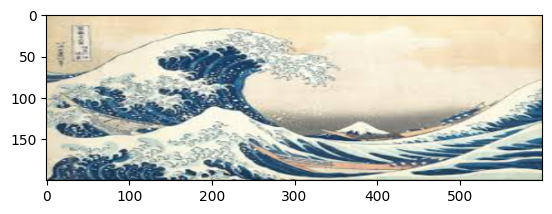

In [26]:
plt.imshow(image)

In [27]:
style_layer = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"] 

In [28]:
style_layer_outputs = [pre_trained_model.get_layer(layer).output for layer in style_layer]

In [29]:
style_model_output = Model(inputs = pre_trained_model.inputs, outputs = style_layer_outputs)

In [30]:
class style_model(tf.keras.Model):       
    def __init__(self,style_model_output,shape):
        super().__init__()     
        self.pre_trained_model = style_model_output
        self.white_image = tf.Variable(tf.ones(shape = shape))       
    
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer   
        
    def gram_matrix(self,x):
        features = K.batch_flatten(K.permute_dimensions(x[0],(2,0,1)))
        gram = K.dot(features,K.transpose(features))
        return gram

    def style_loss(self,style,white_image):   
        S = self.gram_matrix(style)
        C = self.gram_matrix(white_image)
        channels = 3
        size = 200 * 600
        return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))   
        
    def train_step(self, data):            
        
        with tf.GradientTape() as tape:      
            
            loss = tf.zeros(shape=())            
            style_fowards = self.pre_trained_model(data)
            white_noise_fowards = self.pre_trained_model(self.white_image)            
            
            for i in range(len(style_fowards)):    
                sl = self.style_loss(style_fowards[i],white_noise_fowards[i])                    
                loss += (1 / len(style_fowards)) * sl                      
                
        grads = tape.gradient(loss, [self.white_image])[0]            
        self.optimizer.apply_gradients([(grads, self.white_image)])  
        return {"loss": loss}

In [31]:
model = style_model(style_model_output,shape = (1,200,600,3))

In [32]:
opt = optimizer = keras.optimizers.SGD(learning_rate = 0.0001)

In [33]:
model.compile(optimizer = opt)

In [34]:
model.fit(x = np.expand_dims(processed_image,axis = 0),epochs = 10000)

Epoch 1/10000
1/1 [==============================] - 3s 3s/step - loss: 59010830336.0000
Epoch 2/10000
1/1 [==============================] - 0s 43ms/step - loss: 58997923840.0000
Epoch 3/10000
1/1 [==============================] - 0s 36ms/step - loss: 58986606592.0000
Epoch 4/10000
1/1 [==============================] - 0s 40ms/step - loss: 58971914240.0000
Epoch 5/10000
1/1 [==============================] - 0s 37ms/step - loss: 58936012800.0000
Epoch 6/10000
1/1 [==============================] - 0s 38ms/step - loss: 58874441728.0000
Epoch 7/10000
1/1 [==============================] - 0s 35ms/step - loss: 58744688640.0000
Epoch 8/10000
1/1 [==============================] - 0s 36ms/step - loss: 58429276160.0000
Epoch 9/10000
1/1 [==============================] - 0s 35ms/step - loss: 57642090496.0000
Epoch 10/10000
1/1 [==============================] - 0s 35ms/step - loss: 55456595968.0000
Epoch 11/10000
1/1 [==============================] - 0s 34ms/step - loss: 50478755840.0000

In [35]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((200, 600, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [36]:
result = deprocess_image(model.white_image[0].numpy())

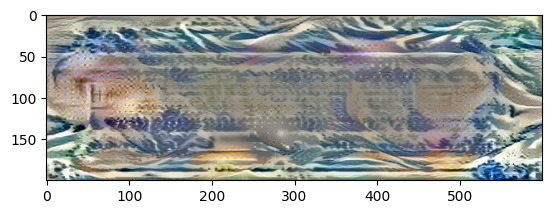

In [37]:
plt.imshow(result)